# Gender recognition from actions with CSN

In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
gcc (Ubuntu 8.4.0-3ubuntu2) 8.4.0
Copyright (C) 2018 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# Install some optional requirements
# !pip install -r requirements/optional.txt

In [2]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMAction2 installation
import mmaction
print(mmaction.__version__)

# Check MMCV installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

import sys
# sys.path.append('/home/actrec/.local/lib/python3.6/site-packages/decord-0.5.3-py3.6-linux-x86_64.egg')
# import decord
import pickle

1.9.0 True
0.16.0
10.2
GCC 7.3


In [7]:
cd /home/robt427nv/childact/

/home/robt427nv/childact


In [8]:
pwd

'/home/robt427nv/childact'

In [11]:
ls

 age-gender-3split-rgb-frames/
 age-gender-3split-vids/
 checkpoints/
 ChildAct_age_gender.csv
 childact_videos_nosplit/
 mmaction2/
 my-mmaction.ipynb*
'Split by Folders and Annotation Files creation.ipynb'*


# CSN gender 

In [10]:
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmaction/recognition/csn/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth \
      -O checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth

--2021-07-21 17:39:20--  https://download.openmmlab.com/mmaction/recognition/csn/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.75.20.25
Connecting to download.openmmlab.com (download.openmmlab.com)|47.75.20.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119580180 (114M) [application/octet-stream]
Saving to: ‘checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth’

checkpoints/ircsn_i 100%[===================>] 114,04M  6,78MB/s    in 17s     

2021-07-21 17:39:39 (6,87 MB/s) - ‘checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth’ saved [119580180/119580180]



In [27]:
from mmcv import Config
cfg = Config.fromfile('mmaction2/configs/recognition/csn/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb.py')

In [28]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
# cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'age-gender-3split-rgb-frames/'
cfg.data_root_val = 'age-gender-3split-rgb-frames/val/'
cfg.ann_file_train = 'age-gender-3split-rgb-frames/childact_train_rgb320_gender.txt'
cfg.ann_file_val = 'age-gender-3split-rgb-frames/childact_val_rgb320_gender.txt'
cfg.ann_file_test = 'age-gender-3split-rgb-frames/childact_test_rgb320_gender.txt'

# cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'age-gender-3split-rgb-frames/childact_test_rgb320_gender.txt'
cfg.data.test.data_prefix = 'age-gender-3split-rgb-frames/test/'

# cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'age-gender-3split-rgb-frames/childact_train_rgb320_gender.txt'
cfg.data.train.data_prefix = 'age-gender-3split-rgb-frames/train/'

# cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'age-gender-3split-rgb-frames/childact_val_rgb320_gender.txt'
cfg.data.val.data_prefix = 'age-gender-3split-rgb-frames/val/'

# cfg.data.test.modality = 'Flow'
# cfg.data.val.modality = 'Flow'
# cfg.data.train.modality = 'Flow'

# cfg.data.train.start_index = 0
# cfg.data.test.start_index = 0
# cfg.data.val.start_index = 0

cfg.data.test.filename_tmpl = '{:03}.jpeg'
cfg.data.train.filename_tmpl = '{:03}.jpeg'
cfg.data.val.filename_tmpl = '{:03}.jpeg'
# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 2
# We can use the pre-trained TSN model
cfg.load_from = 'checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth'
# cfg.resume_from = './childact-mm/latest.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-checkpoints/CSN-gender'

# cfg.img_norm_cfg = dict(mean=[128, 128], std=[128, 128])


# cfg.val_pipeline = [
#     dict(
#         type='SampleFrames',
#         clip_len=32,
#         frame_interval=2,
#         num_clips=1,
#         test_mode=True),
#     dict(type='RawFrameDecode'),
#     dict(type='Resize', scale=(-1, 256)),
#     dict(type='CenterCrop', crop_size=224),
# #     dict(type='Resize', scale=(224, 224), keep_ratio=False),
# #     dict(type='Flip', flip_ratio=0.5)
#     dict(type='Normalize', mean=[128, 128], std=[128, 128]),
#     dict(type='FormatShape', input_format='NCTHW'),
#     dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
#     dict(type='ToTensor', keys=['imgs'])
# ]
# cfg.test_pipeline = [
#     dict(type='SampleFrames', clip_len=32, frame_interval=2, num_clips=10, test_mode=True),
#     dict(type='RawFrameDecode'),
#     dict(type='Resize', scale=(-1, 256)),
#     dict(type='CenterCrop', crop_size=224),
#     dict(type='Normalize', mean=[128, 128], std=[128, 128]),
#     dict(type='FormatShape', input_format='NCTHW'),
#     dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
#     dict(type='ToTensor', keys=['imgs'])
# ]



# cfg.train_pipeline = [
#     dict(type='SampleFrames', clip_len=32, frame_interval=2, num_clips=1),
#     dict(type='RawFrameDecode'),
#     dict(type='Resize', scale=(-1, 256)),
# #     dict(type='RandomCrop', size=224),
#     dict(type='RandomResizedCrop'),
#     dict(type='Resize', scale=(224, 224), keep_ratio=False),
# #     dict(type='Flip', flip_ratio=0.5),
#     dict(type='Normalize', mean=[128, 128], std=[128, 128]),
#     dict(type='FormatShape', input_format='NCTHW'),
#     dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
#     dict(type='ToTensor', keys=['imgs', 'label'])
# ]

# cfg.data.train.pipeline = cfg.train_pipeline
# cfg.data.val.pipeline = cfg.val_pipeline
# cfg.data.test.pipeline = cfg.test_pipeline


# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
# cfg.data.videos_per_gpu = 24
# cfg.optimizer.type = 'Adam'
# cfg.optimizer.weight_decay=0.0001

# cfg.optimizer_config.grad_clip=None
# cfg.optimizer.lr = 0.01

# cfg.lr_config = dict(
#     policy='cyclic',
#     target_ratio=(10, 1e-5),
#     cyclic_times=1,
#     step_ratio_up=0.4,
# )

cfg.total_epochs = 50

# cfg.momentum_config = dict(
#     policy='cyclic',
#     target_ratio=(0.85 / 0.95, 1),
#     cyclic_times=1,
#     step_ratio_up=0.4,
# )

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 20
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 100

# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)

cfg.data.videos_per_gpu=8

# cfg.model.backbone.in_channels = 2

cfg.output_config = dict(out=f'{cfg.work_dir}/results.json')
# We can initialize the logger for training and have a look
# at the final config used for training
# del cfg.optimizer['momentum']
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='Recognizer3D',
    backbone=dict(
        type='ResNet3dCSN',
        pretrained2d=False,
        pretrained=
        'https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r152_ig65m_20200807-771c4135.pth',
        depth=152,
        with_pool2=False,
        bottleneck_mode='ir',
        norm_eval=True,
        zero_init_residual=False,
        bn_frozen=True),
    cls_head=dict(
        type='I3DHead',
        num_classes=2,
        in_channels=2048,
        spatial_type='avg',
        dropout_ratio=0.5,
        init_std=0.01),
    train_cfg=None,
    test_cfg=dict(average_clips='prob'))
checkpoint_config = dict(interval=20)
log_config = dict(interval=100, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = 'checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth'
resume_from = None
workflow = [('train', 1)]
dataset_type = 'RawframeDataset

In [29]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-07-21 19:01:01,494 - mmaction - INFO - load model from: https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r152_ig65m_20200807-771c4135.pth
2021-07-21 19:01:01,495 - mmaction - INFO - Use load_from_http loader
2021-07-21 19:01:01,711 - mmaction - INFO - load checkpoint from checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth
2021-07-21 19:01:01,712 - mmaction - INFO - Use load_from_local loader
2021-07-21 19:01:01,873 - mmaction - WARNING - The model and loaded state dict do not match exactly

size mismatch for cls_head.fc_cls.weight: copying a param with shape torch.Size([400, 2048]) from checkpoint, the shape in current model is torch.Size([2, 2048]).
size mismatch for cls_head.fc_cls.bias: copying a param with shape torch.Size([400]) from checkpoint, the shape in current model is torch.Size([2]).
2021-07-21 19:01:01,875 - mmaction - INFO - Start running, host: robt427nv@robt427NV, work_dir: /home/robt427nv/ch

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 118/118, 18.6 task/s, elapsed: 6s, ETA:     0s

2021-07-21 19:11:30,240 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-07-21 19:11:30,242 - mmaction - INFO - 
top1_acc	0.8729
top5_acc	1.0000
2021-07-21 19:11:30,242 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-07-21 19:11:30,243 - mmaction - INFO - 
mean_acc	0.8617
2021-07-21 19:11:30,570 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2021-07-21 19:11:30,571 - mmaction - INFO - Best top1_acc is 0.8729 at 5 epoch.
2021-07-21 19:11:30,572 - mmaction - INFO - Epoch(val) [5][15]	top1_acc: 0.8729, top5_acc: 1.0000, mean_class_accuracy: 0.8617
2021-07-21 19:13:15,414 - mmaction - INFO - Epoch [6][100/119]	lr: 5.351e-05, eta: 1:19:47, time: 1.048, data_time: 0.035, memory: 21985, top1_acc: 0.8025, top5_acc: 1.0000, loss_cls: 0.4066, loss: 0.4066, grad_norm: 21.0505
2021-07-21 19:15:19,363 - mmaction - INFO - Epoch [7][100/119]	lr: 6.054e-05, eta: 1:17:39, time: 1.053, data_time: 0.039, memory: 21985, top1_acc: 0.8000, top5_acc: 1.0000, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 118/118, 16.1 task/s, elapsed: 7s, ETA:     0s

2021-07-21 19:21:57,274 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-07-21 19:21:57,300 - mmaction - INFO - 
top1_acc	0.8814
top5_acc	1.0000
2021-07-21 19:21:57,304 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-07-21 19:21:57,316 - mmaction - INFO - 
mean_acc	0.8719
2021-07-21 19:21:58,213 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_10.pth.
2021-07-21 19:21:58,226 - mmaction - INFO - Best top1_acc is 0.8814 at 10 epoch.
2021-07-21 19:21:58,251 - mmaction - INFO - Epoch(val) [10][15]	top1_acc: 0.8814, top5_acc: 1.0000, mean_class_accuracy: 0.8719
2021-07-21 19:23:43,644 - mmaction - INFO - Epoch [11][100/119]	lr: 8.866e-05, eta: 1:09:48, time: 1.053, data_time: 0.041, memory: 21985, top1_acc: 0.8337, top5_acc: 1.0000, loss_cls: 0.3496, loss: 0.3496, grad_norm: 18.7204
2021-07-21 19:25:47,645 - mmaction - INFO - Epoch [12][100/119]	lr: 9.569e-05, eta: 1:07:55, time: 1.053, data_time: 0.039, memory: 21985, top1_acc: 0.8150, top5_acc: 1.0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 118/118, 19.2 task/s, elapsed: 6s, ETA:     0s

2021-07-21 19:32:23,955 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-07-21 19:32:23,956 - mmaction - INFO - 
top1_acc	0.8898
top5_acc	1.0000
2021-07-21 19:32:23,957 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-07-21 19:32:23,958 - mmaction - INFO - 
mean_acc	0.8910
2021-07-21 19:32:24,315 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_15.pth.
2021-07-21 19:32:24,316 - mmaction - INFO - Best top1_acc is 0.8898 at 15 epoch.
2021-07-21 19:32:24,316 - mmaction - INFO - Epoch(val) [15][15]	top1_acc: 0.8898, top5_acc: 1.0000, mean_class_accuracy: 0.8910
2021-07-21 19:34:09,228 - mmaction - INFO - Epoch [16][100/119]	lr: 1.238e-04, eta: 1:00:33, time: 1.049, data_time: 0.036, memory: 21985, top1_acc: 0.8225, top5_acc: 1.0000, loss_cls: 0.3533, loss: 0.3533, grad_norm: 17.0690
2021-07-21 19:36:13,326 - mmaction - INFO - Epoch [17][100/119]	lr: 1.250e-04, eta: 0:58:45, time: 1.054, data_time: 0.039, memory: 21985, top1_acc: 0.8575, top5_acc: 1.0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 118/118, 17.9 task/s, elapsed: 7s, ETA:     0s

2021-07-21 19:42:50,192 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-07-21 19:42:50,194 - mmaction - INFO - 
top1_acc	0.8814
top5_acc	1.0000
2021-07-21 19:42:50,194 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-07-21 19:42:50,196 - mmaction - INFO - 
mean_acc	0.8690
2021-07-21 19:42:50,197 - mmaction - INFO - Epoch(val) [20][15]	top1_acc: 0.8814, top5_acc: 1.0000, mean_class_accuracy: 0.8690
2021-07-21 19:44:35,200 - mmaction - INFO - Epoch [21][100/119]	lr: 1.250e-04, eta: 0:51:33, time: 1.050, data_time: 0.037, memory: 21985, top1_acc: 0.8625, top5_acc: 1.0000, loss_cls: 0.2920, loss: 0.2920, grad_norm: 16.2119
2021-07-21 19:46:39,343 - mmaction - INFO - Epoch [22][100/119]	lr: 1.250e-04, eta: 0:49:46, time: 1.054, data_time: 0.040, memory: 21985, top1_acc: 0.8625, top5_acc: 1.0000, loss_cls: 0.2806, loss: 0.2806, grad_norm: 15.7211
2021-07-21 19:48:42,914 - mmaction - INFO - Epoch [23][100/119]	lr: 1.250e-04, eta: 0:47:58, time: 1.049, data_time: 0.038, memor

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 118/118, 17.7 task/s, elapsed: 7s, ETA:     0s

2021-07-21 19:53:15,530 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-07-21 19:53:15,533 - mmaction - INFO - 
top1_acc	0.8390
top5_acc	1.0000
2021-07-21 19:53:15,534 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-07-21 19:53:15,536 - mmaction - INFO - 
mean_acc	0.8209
2021-07-21 19:53:15,537 - mmaction - INFO - Epoch(val) [25][15]	top1_acc: 0.8390, top5_acc: 1.0000, mean_class_accuracy: 0.8209
2021-07-21 19:55:00,636 - mmaction - INFO - Epoch [26][100/119]	lr: 1.250e-04, eta: 0:42:37, time: 1.051, data_time: 0.038, memory: 21985, top1_acc: 0.8888, top5_acc: 1.0000, loss_cls: 0.2464, loss: 0.2464, grad_norm: 15.2354
2021-07-21 19:57:04,280 - mmaction - INFO - Epoch [27][100/119]	lr: 1.250e-04, eta: 0:40:51, time: 1.049, data_time: 0.037, memory: 21985, top1_acc: 0.8625, top5_acc: 1.0000, loss_cls: 0.2844, loss: 0.2844, grad_norm: 18.1862
2021-07-21 19:59:08,035 - mmaction - INFO - Epoch [28][100/119]	lr: 1.250e-04, eta: 0:39:04, time: 1.050, data_time: 0.038, memor

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 118/118, 17.8 task/s, elapsed: 7s, ETA:     0s

2021-07-21 20:03:40,405 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-07-21 20:03:40,406 - mmaction - INFO - 
top1_acc	0.8898
top5_acc	1.0000
2021-07-21 20:03:40,407 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-07-21 20:03:40,407 - mmaction - INFO - 
mean_acc	0.8762
2021-07-21 20:03:40,408 - mmaction - INFO - Epoch(val) [30][15]	top1_acc: 0.8898, top5_acc: 1.0000, mean_class_accuracy: 0.8762
2021-07-21 20:05:25,332 - mmaction - INFO - Epoch [31][100/119]	lr: 1.250e-04, eta: 0:33:45, time: 1.049, data_time: 0.036, memory: 21985, top1_acc: 0.8675, top5_acc: 1.0000, loss_cls: 0.2397, loss: 0.2397, grad_norm: 11.6113
2021-07-21 20:07:28,761 - mmaction - INFO - Epoch [32][100/119]	lr: 1.250e-04, eta: 0:31:59, time: 1.048, data_time: 0.034, memory: 21985, top1_acc: 0.8738, top5_acc: 1.0000, loss_cls: 0.2408, loss: 0.2408, grad_norm: 14.7725
2021-07-21 20:09:32,256 - mmaction - INFO - Epoch [33][100/119]	lr: 1.250e-05, eta: 0:30:12, time: 1.047, data_time: 0.035, memor

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 118/118, 18.8 task/s, elapsed: 6s, ETA:     0s

2021-07-21 20:14:04,437 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-07-21 20:14:04,438 - mmaction - INFO - 
top1_acc	0.8814
top5_acc	1.0000
2021-07-21 20:14:04,439 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-07-21 20:14:04,440 - mmaction - INFO - 
mean_acc	0.8749
2021-07-21 20:14:04,441 - mmaction - INFO - Epoch(val) [35][15]	top1_acc: 0.8814, top5_acc: 1.0000, mean_class_accuracy: 0.8749
2021-07-21 20:15:49,050 - mmaction - INFO - Epoch [36][100/119]	lr: 1.250e-05, eta: 0:24:54, time: 1.046, data_time: 0.033, memory: 21985, top1_acc: 0.8912, top5_acc: 1.0000, loss_cls: 0.2052, loss: 0.2052, grad_norm: 14.0746
2021-07-21 20:17:52,772 - mmaction - INFO - Epoch [37][100/119]	lr: 1.250e-05, eta: 0:23:09, time: 1.051, data_time: 0.039, memory: 21985, top1_acc: 0.8762, top5_acc: 1.0000, loss_cls: 0.2203, loss: 0.2203, grad_norm: 13.1916
2021-07-21 20:19:56,322 - mmaction - INFO - Epoch [38][100/119]	lr: 1.250e-05, eta: 0:21:23, time: 1.049, data_time: 0.037, memor

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 118/118, 14.5 task/s, elapsed: 8s, ETA:     0s

2021-07-21 20:24:30,622 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-07-21 20:24:30,699 - mmaction - INFO - 
top1_acc	0.8814
top5_acc	1.0000
2021-07-21 20:24:30,722 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-07-21 20:24:30,780 - mmaction - INFO - 
mean_acc	0.8749
2021-07-21 20:24:30,818 - mmaction - INFO - Epoch(val) [40][15]	top1_acc: 0.8814, top5_acc: 1.0000, mean_class_accuracy: 0.8749
2021-07-21 20:26:16,018 - mmaction - INFO - Epoch [41][100/119]	lr: 1.250e-05, eta: 0:16:06, time: 1.050, data_time: 0.038, memory: 21985, top1_acc: 0.9050, top5_acc: 1.0000, loss_cls: 0.1927, loss: 0.1927, grad_norm: 13.8017
2021-07-21 20:28:19,638 - mmaction - INFO - Epoch [42][100/119]	lr: 1.250e-05, eta: 0:14:20, time: 1.049, data_time: 0.035, memory: 21985, top1_acc: 0.8850, top5_acc: 1.0000, loss_cls: 0.2039, loss: 0.2039, grad_norm: 13.4039
2021-07-21 20:30:23,117 - mmaction - INFO - Epoch [43][100/119]	lr: 1.250e-05, eta: 0:12:35, time: 1.048, data_time: 0.035, memor

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 118/118, 18.1 task/s, elapsed: 7s, ETA:     0s

2021-07-21 20:34:56,102 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-07-21 20:34:56,103 - mmaction - INFO - 
top1_acc	0.8898
top5_acc	1.0000
2021-07-21 20:34:56,104 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-07-21 20:34:56,106 - mmaction - INFO - 
mean_acc	0.8821
2021-07-21 20:34:56,106 - mmaction - INFO - Epoch(val) [45][15]	top1_acc: 0.8898, top5_acc: 1.0000, mean_class_accuracy: 0.8821
2021-07-21 20:36:41,192 - mmaction - INFO - Epoch [46][100/119]	lr: 1.250e-05, eta: 0:07:18, time: 1.051, data_time: 0.037, memory: 21985, top1_acc: 0.8912, top5_acc: 1.0000, loss_cls: 0.2117, loss: 0.2117, grad_norm: 12.4332
2021-07-21 20:38:44,905 - mmaction - INFO - Epoch [47][100/119]	lr: 1.250e-05, eta: 0:05:33, time: 1.050, data_time: 0.037, memory: 21985, top1_acc: 0.9038, top5_acc: 1.0000, loss_cls: 0.1846, loss: 0.1846, grad_norm: 12.7917
2021-07-21 20:40:48,716 - mmaction - INFO - Epoch [48][100/119]	lr: 1.250e-05, eta: 0:03:47, time: 1.050, data_time: 0.036, memor

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 118/118, 18.6 task/s, elapsed: 6s, ETA:     0s

2021-07-21 20:45:21,508 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-07-21 20:45:21,510 - mmaction - INFO - 
top1_acc	0.8814
top5_acc	1.0000
2021-07-21 20:45:21,511 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-07-21 20:45:21,513 - mmaction - INFO - 
mean_acc	0.8749
2021-07-21 20:45:21,513 - mmaction - INFO - Epoch(val) [50][15]	top1_acc: 0.8814, top5_acc: 1.0000, mean_class_accuracy: 0.8749


In [30]:
import pickle

with open(f"{cfg.work_dir}/model50e_ig65m", 'wb') as f:
    pickle.dump(model, f)

In [ ]:
# import os.path as osp

# from mmaction.datasets import build_dataset
# from mmaction.models import build_model
# from mmaction.apis import train_model
# import pickle
# import mmcv
# # Build the dataset
# datasets = [build_dataset(cfg.data.train)]

# # Build the recognizer
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# model = pickle.load(open(f"{cfg.work_dir}/model50e", 'rb'))

In [31]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel
# from mmaction.models import build_model
# from mmaction.datasets import build_dataset

# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=1,
        workers_per_gpu=1,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')
    
output_config = cfg.output_config
dataset.dump_results(outputs, **output_config)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 119/119, 0.2 task/s, elapsed: 591s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.9580
top5_acc	1.0000

Evaluating mean_class_accuracy ...

mean_acc	0.9608
top1_acc: 0.9580
top5_acc: 1.0000
mean_class_accuracy: 0.9608


Matplotlib is building the font cache; this may take a moment.


<AxesSubplot:>

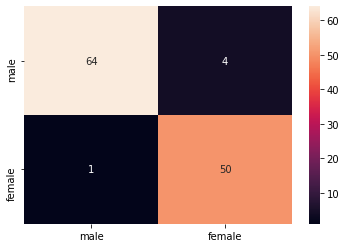

In [33]:
import seaborn as sns
import numpy as np
from mmaction.core import confusion_matrix 

gt_labels = [ann['label'] for ann in dataset.load_annotations()]
pred = np.argmax(outputs, axis=1)
cf_mat = confusion_matrix(pred, gt_labels).astype(float)

sns.heatmap(cf_mat, annot=True, xticklabels = ['male', 'female'], yticklabels = ['male', 'female'])